In [1]:
import polars as pl
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
import numpy as np

sns.set_style("darkgrid")
plt.rcParams['text.usetex'] = False

In [2]:
def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):

    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame):

    return (((y_hat - y_obs.to_series())**2).sum()/y_obs.shape[0])**0.5

In [3]:
sheet_names = ('Yt', 'Yv', 'Xt', "Xv")

# Importowanie nieautoskalowanego zestawu danych

Yt i Yv - wartości modelowanej wielkości (energia adsorpcji aminokwasu na powierzchni nanocząstki złota) odpowiednio dla związków ze zbioru uczącego i walidacyjnego

Xt i Xv - deskryptory obliczone odpowiednio dla związku ze zmienną zależną

In [4]:
input_data = pl.read_excel(
    source="AA-AuNP.xlsx",
    sheet_name=sheet_names,
    engine='openpyxl'
)

In [5]:
input_data['Xt'].head()

Amino acid,HOMO[eV],LUMO [eV],Ionization potential [eV],Electron affinity [eV],Hardness,Softness,Electronegativity [Ev],Polarizability [au],Enthalpy [Hartree],Atom count,Heavy atom count,Asymmetric atom count,Rotatable bond count,Ring count,Aromatic ring count,Hetero ring count,FSP3,Hydrogen bond donor count,Hydrogen bond acceptor count,Formal charge,Topological polar surface area,Polarizability,Molar refractivity,HLB,logP,Van der Waals volume,Van der Waals surface area,Solvent accessible surface area,Minimum projection area,Maximum projection area,Minimum projection radius,Maximum projection radius
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""A""",-5.952265,-1.22425,8.823835,-0.459455,4.641645,0.215441,4.18219,55.04,-323.370475,13,6,1,1,0,0,0,0.67,2,3,0,63.32,8.36,20.5,17.181,-2.841,84.93,142.15,235.74,22.27,29.61,3.02,3.84
"""C""",-5.795527,-1.3233,7.93835,0.030901,3.953725,0.252926,3.984626,74.97,-721.393083,14,7,1,2,0,0,0,0.67,3,3,0,63.32,11.42,28.22,19.67,-2.795,103.45,159.9,255.87,22.03,36.01,3.02,4.51
"""D""",-6.279077,-1.846307,8.812125,-0.04095,4.426538,0.22591,4.385588,74.0,-511.800495,16,9,1,3,0,0,0,0.5,3,5,0,100.62,10.9,26.53,18.948,-3.504,112.61,177.91,261.0,22.51,39.04,3.07,4.73
"""E""",-6.122066,-1.376907,8.569092,-0.169841,4.369466,0.228861,4.199626,85.88,-551.038643,19,10,1,4,0,0,0,0.6,3,5,0,100.62,12.69,31.29,17.981,-3.249,129.67,209.34,289.78,24.45,45.42,3.2,5.52
"""F""",-5.988185,-1.385615,7.80233,-0.233017,4.017674,0.2489,3.784656,123.73,-554.096836,23,12,1,3,1,1,0,0.22,2,3,0,63.32,17.89,45.12,13.109,-1.184,155.64,246.8,319.0,28.81,53.97,3.49,5.8


# Standaryzacja danych

In [6]:
std_data = {
    "Xt": input_data['Xt'].select(pl.exclude("Amino acid")).select((pl.all() - pl.all().mean())/pl.all().std()),
    "Xv": input_data['Xv'].select(pl.exclude("Amino acid")).select((pl.all() - pl.all().mean())/pl.all().std()),
    "Yt": input_data["Yt"].select(pl.exclude("Amino acid")),
    "Yv": input_data['Yv'].select(pl.exclude("Amino acid"))
}

In [7]:
std_data['Xt'].head()

HOMO[eV],LUMO [eV],Ionization potential [eV],Electron affinity [eV],Hardness,Softness,Electronegativity [Ev],Polarizability [au],Enthalpy [Hartree],Atom count,Heavy atom count,Asymmetric atom count,Rotatable bond count,Ring count,Aromatic ring count,Hetero ring count,FSP3,Hydrogen bond donor count,Hydrogen bond acceptor count,Formal charge,Topological polar surface area,Polarizability,Molar refractivity,HLB,logP,Van der Waals volume,Van der Waals surface area,Solvent accessible surface area,Minimum projection area,Maximum projection area,Minimum projection radius,Maximum projection radius
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.512666,0.278151,1.069402,-0.964851,1.228204,-1.155538,0.809549,-1.293044,1.446939,-1.373412,-1.388808,-0.126892,-1.565007,-0.525173,-0.454447,-0.409447,0.330573,-0.955377,-0.809712,NaN,-0.8428,-1.30417,-1.249379,-0.20927,-0.109167,-1.469964,-1.433329,-1.258939,-0.846005,-1.45357,-0.727419,-1.427082
-0.104009,-0.187138,-0.39681,1.891728,-0.854217,0.809337,0.14344,-0.568139,-1.594197,-1.151894,-0.974239,-0.126892,-0.719057,-0.525173,-0.454447,-0.409447,0.330573,0.409447,-0.809712,NaN,-0.8428,-0.506417,-0.517406,0.610744,-0.062388,-0.818842,-1.038274,-0.746644,-0.915267,-0.799269,-0.727419,-0.625955
-1.364744,-2.643964,1.050014,1.473159,0.577048,-0.606764,1.495327,-0.603421,0.007218,-0.708858,-0.145099,-0.126892,0.126892,-0.525173,-0.454447,-0.409447,-0.455405,0.409447,1.503751,NaN,1.00711,-0.641983,-0.677644,0.372877,-0.783387,-0.496797,-0.637431,-0.616089,-0.776744,-0.489499,-0.60135,-0.362899
-0.955378,-0.438956,0.647592,0.722304,0.404286,-0.452096,0.868336,-0.171315,-0.292585,-0.044304,0.26947,-0.126892,0.972842,-0.525173,-0.454447,-0.409447,0.006935,0.409447,1.503751,NaN,1.00711,-0.175323,-0.226324,0.054294,-0.524072,0.102995,0.062096,0.116341,-0.216876,0.162757,-0.27357,0.581714
-0.606317,-0.479861,-0.622036,0.354265,-0.660635,0.598315,-0.530778,1.205387,-0.315952,0.841769,1.098609,-0.126892,0.126892,1.225403,1.36334,-0.409447,-1.749956,-0.955377,-0.809712,NaN,-0.8428,1.180336,1.08497,-1.550811,1.575876,1.016042,0.895831,0.85997,1.041382,1.036862,0.457631,0.916513


In [8]:
std_data['Xt'].select(pl.col("HOMO[eV]"), pl.col("Polarizability [au]"), pl.col("Topological polar surface area"))

HOMO[eV],Polarizability [au],Topological polar surface area
f64,f64,f64
-0.512666,-1.293044,-0.8428
-0.104009,-0.568139,-0.8428
-1.364744,-0.603421,1.00711
-0.955378,-0.171315,1.00711
-0.606317,1.205387,-0.8428
…,…,…
-0.861727,-1.123185,0.160516
-0.999365,-0.678348,0.160516
-0.461584,-0.409191,-0.8428


# Modelowanie PLS

In [9]:
hidden_variables = {
    "Xt": std_data['Xt'].select(pl.col("HOMO[eV]"), pl.col("Polarizability [au]"), pl.col("Topological polar surface area")),
    'Xv': std_data['Xv'].select(pl.col("HOMO[eV]"), pl.col("Polarizability [au]"), pl.col("Topological polar surface area"))
}

In [10]:
PLS_model = PLSRegression(
    n_components=1
).fit(
    hidden_variables['Xt'],
    std_data['Yt']
)

In [11]:
PLS_model

PLSRegression(n_components=1)

In [12]:
PLS_predictions = {
    "Yt": PLS_model.predict(hidden_variables['Xt']),
    "Yv": PLS_model.predict(hidden_variables["Xv"])
}

# Wykres $y_{pred}$ od $y_{obs}$ z podziałem na zbiór uczący i walidacyjny

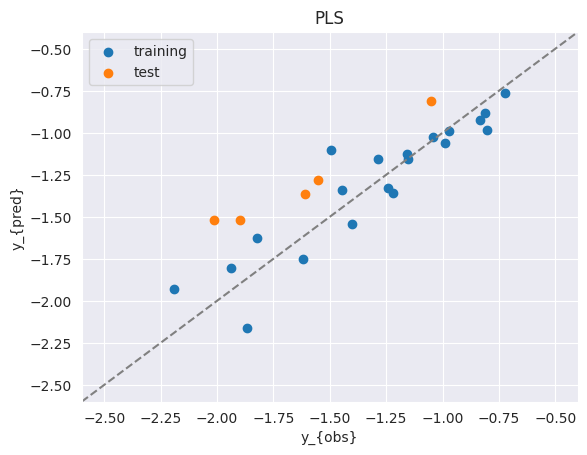

In [13]:
plt.scatter(std_data['Yt'], PLS_predictions['Yt'], label="training")
plt.scatter(std_data['Yv'], PLS_predictions['Yv'], label="test")
plt.legend()
plt.xlabel("y_{obs}")
plt.ylabel("y_{pred}")
plt.title('PLS')
plt.axline((-2.5,-2.5), (-0.5,-0.5), c="grey", ls="dashed")

# Obliczenie statystyk

In [14]:
#PLS_predictions['Yt'].shape
std_data['Yt']

AA-AuNP
f64
-0.813347
-1.493549
-0.973356
-1.28657
-1.4453
…
-0.835206
-0.804496
-0.98744


In [15]:
std_data['Xt']

HOMO[eV],LUMO [eV],Ionization potential [eV],Electron affinity [eV],Hardness,Softness,Electronegativity [Ev],Polarizability [au],Enthalpy [Hartree],Atom count,Heavy atom count,Asymmetric atom count,Rotatable bond count,Ring count,Aromatic ring count,Hetero ring count,FSP3,Hydrogen bond donor count,Hydrogen bond acceptor count,Formal charge,Topological polar surface area,Polarizability,Molar refractivity,HLB,logP,Van der Waals volume,Van der Waals surface area,Solvent accessible surface area,Minimum projection area,Maximum projection area,Minimum projection radius,Maximum projection radius
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.512666,0.278151,1.069402,-0.964851,1.228204,-1.155538,0.809549,-1.293044,1.446939,-1.373412,-1.388808,-0.126892,-1.565007,-0.525173,-0.454447,-0.409447,0.330573,-0.955377,-0.809712,NaN,-0.8428,-1.30417,-1.249379,-0.20927,-0.109167,-1.469964,-1.433329,-1.258939,-0.846005,-1.45357,-0.727419,-1.427082
-0.104009,-0.187138,-0.39681,1.891728,-0.854217,0.809337,0.14344,-0.568139,-1.594197,-1.151894,-0.974239,-0.126892,-0.719057,-0.525173,-0.454447,-0.409447,0.330573,0.409447,-0.809712,NaN,-0.8428,-0.506417,-0.517406,0.610744,-0.062388,-0.818842,-1.038274,-0.746644,-0.915267,-0.799269,-0.727419,-0.625955
-1.364744,-2.643964,1.050014,1.473159,0.577048,-0.606764,1.495327,-0.603421,0.007218,-0.708858,-0.145099,-0.126892,0.126892,-0.525173,-0.454447,-0.409447,-0.455405,0.409447,1.503751,NaN,1.00711,-0.641983,-0.677644,0.372877,-0.783387,-0.496797,-0.637431,-0.616089,-0.776744,-0.489499,-0.60135,-0.362899
-0.955378,-0.438956,0.647592,0.722304,0.404286,-0.452096,0.868336,-0.171315,-0.292585,-0.044304,0.26947,-0.126892,0.972842,-0.525173,-0.454447,-0.409447,0.006935,0.409447,1.503751,NaN,1.00711,-0.175323,-0.226324,0.054294,-0.524072,0.102995,0.062096,0.116341,-0.216876,0.162757,-0.27357,0.581714
-0.606317,-0.479861,-0.622036,0.354265,-0.660635,0.598315,-0.530778,1.205387,-0.315952,0.841769,1.098609,-0.126892,0.126892,1.225403,1.36334,-0.409447,-1.749956,-0.955377,-0.809712,NaN,-0.8428,1.180336,1.08497,-1.550811,1.575876,1.016042,0.895831,0.85997,1.041382,1.036862,0.457631,0.916513
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.861727,0.385525,0.889353,-1.012294,1.075951,-1.03183,0.612512,-1.123185,0.872648,-1.151894,-0.974239,-0.126892,-0.719057,-0.525173,-0.454447,-0.409447,0.330573,0.409447,0.34702,NaN,0.160516,-1.121678,-1.103364,0.610744,-1.173886,-1.16831,-1.223894,-1.233744,-0.802717,-1.145844,-0.500495,-0.900969
-0.999365,-0.298347,0.819104,-0.234073,0.809543,-0.808722,0.766195,-0.678348,0.572761,-0.48734,-0.559669,2.410957,-0.719057,-0.525173,-0.454447,-0.409447,0.700445,0.409447,0.34702,NaN,0.160516,-0.649804,-0.684281,0.184429,-0.749829,-0.568519,-0.579341,-0.919954,-0.219762,-0.617292,0.281134,-0.948797
-0.461584,1.109023,0.749636,-0.815468,0.897099,-0.883003,0.527223,-0.409191,0.847308,-0.044304,-0.559669,-0.126892,-0.719057,-0.525173,-0.454447,-0.409447,0.931615,-0.955377,-0.809712,NaN,-0.8428,-0.355209,-0.396991,-0.921552,0.793862,-0.270381,-0.098374,-0.419112,0.478629,-0.38113,0.558486,-0.912926


$R^2$

In [16]:
PLS_R2 = R2(
    PLS_predictions['Yt'].flatten(),
    std_data['Yt']
)
PLS_R2

0.847115954331954

$RMSE_c$

In [17]:
PLS_RMSEc = RMSE(
    PLS_predictions['Yt'].flatten(),
    std_data['Yt']
)
PLS_RMSEc

0.1593818955165241

In [18]:
loo = LeaveOneOut()
loo.get_n_splits(hidden_variables['Xt'])

20

In [19]:
std_data['Yt']

AA-AuNP
f64
-0.813347
-1.493549
-0.973356
-1.28657
-1.4453
…
-0.835206
-0.804496
-0.98744


In [20]:
def predictions_cv(regression_model, validation_sets, X_training, Y_training) -> pl.Series:
    predictions = pl.Series(dtype=pl.Float64)

    for _, test_set in validation_sets:
        x = (
            X_training.with_row_index()
            .filter(~pl.col("index").is_in(test_set))
            .drop(pl.col("index"))
        )

        y = (
            Y_training.with_row_index()
            .filter(~pl.col("index").is_in(test_set))
            .drop(pl.col("index"))
        )

        PCR_model = regression_model().fit(X=x, y=y)

        prediction = PCR_model.predict(
            X_training.with_row_index()
            .filter(pl.col("index").is_in(test_set))
            .drop(pl.col("index"))
        )


        predictions.append(pl.Series(prediction.flatten()))

    return predictions

In [21]:
PLS_predictions_loo = predictions_cv(PLSRegression, loo.split(hidden_variables['Xt']), hidden_variables['Xt'], std_data['Yt'])

$Q^2_{cv}$

In [22]:
PLS_Q2cv = Q2(PLS_predictions_loo, std_data['Yt'])
PLS_Q2cv

0.7406684385546339

$RMSE_{cv}$

In [23]:
PLS_RMSEcv = RMSE(PLS_predictions_loo, std_data['Yt'])
PLS_RMSEcv

0.2075800401930263

$Q^2_{ext}$

In [24]:
PLS_Q2ext = Q2(
    PLS_predictions['Yv'].flatten(),
    std_data['Yv']
)
PLS_Q2ext

-0.015099818086310002

$RMSE_{ext}$

In [25]:
PLS_RMSEext = RMSE(
    PLS_predictions['Yv'].flatten(),
    std_data['Yv']
)
PLS_RMSEext

0.3373207669074359

Zbudować modele MLR i PCR, powtórzyć dla nich kroki 3 i 4., a następnie porównać
wyniki uzyskane wszystkimi trzema metodami.

# Model MLR

In [26]:
std_data['Yt']

AA-AuNP
f64
-0.813347
-1.493549
-0.973356
-1.28657
-1.4453
…
-0.835206
-0.804496
-0.98744


In [27]:
MLR_model = LinearRegression().fit(hidden_variables['Xt'], std_data['Yt'])

In [28]:
MLR_predictions = {
    'Yt': MLR_model.predict(hidden_variables['Xt']),
    "Yv": MLR_model.predict(hidden_variables['Xv'])
}

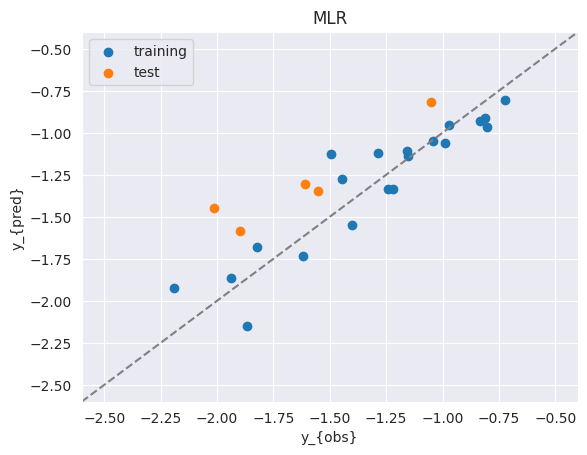

In [29]:
plt.scatter(std_data['Yt'], MLR_predictions['Yt'], label="training")
plt.scatter(std_data['Yv'], MLR_predictions['Yv'], label="test")
plt.legend()
plt.xlabel("y_{obs}")
plt.ylabel("y_{pred}")
plt.title('MLR')
plt.axline((-2.5,-2.5), (-0.5,-0.5), c="grey", ls="dashed")

$R^2$

In [30]:
MLR_R2 = R2(
    MLR_predictions['Yt'].flatten(),
    std_data['Yt']
)
MLR_R2

0.8527047624112475

$RMSE_c$

In [31]:
MLR_RMSEc = RMSE(
    MLR_predictions['Yt'].flatten(),
    std_data['Yt']
)
MLR_RMSEc

0.15644160282297642

In [32]:
MLR_predictions_loo = predictions_cv(LinearRegression, loo.split(hidden_variables['Xt']), hidden_variables['Xt'], std_data['Yt'])

$Q^2_{cv}$

In [33]:
MLR_Q2cv = Q2(
    MLR_predictions_loo,
    std_data['Yt']
)
MLR_Q2cv

0.7332650374413231

$RMSE_{cv}$

In [34]:
MLR_RMSEcv = RMSE(
    MLR_predictions_loo,
    std_data['Yt']
)
MLR_RMSEcv

0.21052218880326923

$Q^2_{ext}$

In [35]:
MLR_Q2ext = Q2(
    MLR_predictions['Yv'].flatten(),
    std_data['Yv']
)
MLR_Q2ext

-0.0741898090668851

$RMSE_{ext}$

In [36]:
MLR_RMSEext = RMSE(
    MLR_predictions['Yv'].flatten(),
    std_data['Yv']
)
MLR_RMSEext

0.3469997948226945

# Model PCR

In [37]:
PCA_model = PCA(n_components=1)

PC = {
    "Yt": pl.DataFrame(
        PCA_model.fit_transform(hidden_variables['Xt']),
        schema=[f"PC{i+1}" for i in range(PCA_model.n_components_)]
    ),

    "Yv": pl.DataFrame(
    PCA_model.fit_transform(hidden_variables['Xv']),
    schema=[f"PC{i+1}" for i in range(PCA_model.n_components_)]
    )
}

In [38]:
PC['Yt']

PC1
f64
-1.4848
-0.721324
-0.99539
-0.430636
0.152945
…
-1.283462
-1.071884
-0.849721


In [39]:
PCR_model = LinearRegression().fit(PC['Yt'], std_data['Yt'])

In [40]:
PCR_predictions = {
    "Yt": PCR_model.predict(PC['Yt']),
    "Yv": PCR_model.predict(PC['Yv'])
}

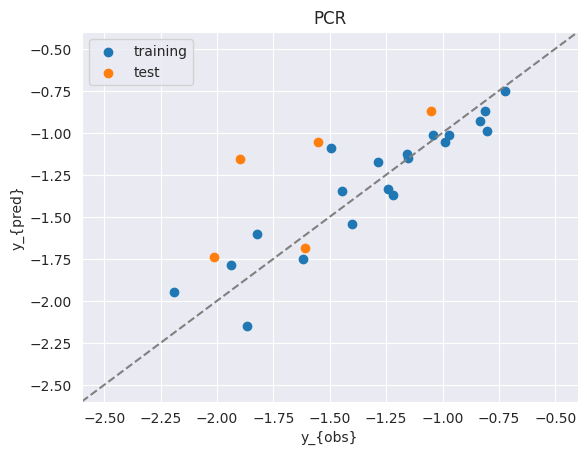

In [41]:
plt.scatter(std_data['Yt'], PCR_predictions['Yt'], label="training")
plt.scatter(std_data['Yv'], PCR_predictions['Yv'], label="test")
plt.legend()
plt.xlabel("y_{obs}")
plt.ylabel("y_{pred}")
plt.title('PCR')
plt.axline((-2.5,-2.5), (-0.5,-0.5), c="grey", ls="dashed")

$R^2$

In [42]:
PCR_R2 = R2(
    PCR_predictions['Yt'].flatten(),
    std_data['Yt']
)
PCR_R2

0.8428816618342894

$RMSE_c$

In [43]:
PCR_RMSEc = RMSE(
    PCR_predictions['Yt'].flatten(),
    std_data['Yt']
)
PCR_RMSEc

0.16157395014708945

In [44]:
PCR_predictions_loo = predictions_cv(LinearRegression, loo.split(PC['Yt']), PC['Yt'], std_data['Yt'])

$Q^2_{cv}$

In [45]:
PCR_Q2cv = Q2(
    PCR_predictions_loo,
    std_data['Yt']
)
PCR_Q2cv

0.7863910505191459

$RMSE_{cv}$

In [46]:
PCR_RMSEcv = RMSE(
    PCR_predictions_loo,
    std_data['Yt']
)
PCR_RMSEcv

0.18839424254214643

$Q^2_{ext}$

In [47]:
PCR_Q2ext = Q2(
    PCR_predictions['Yv'].flatten(),
    std_data['Yv']
)
PCR_Q2ext

-0.619386475987568

$RMSE_{ext}$

In [48]:
PCR_RMSEext = RMSE(
    PCR_predictions['Yv'].flatten(),
    std_data['Yv']
)
PCR_RMSEext

0.4260533241204854

In [49]:
stats = pl.DataFrame({
    'values': [
        PLS_R2,
        PLS_RMSEc,
        PLS_Q2cv,
        PLS_RMSEcv,
        PLS_Q2ext,
        PLS_RMSEext,
        MLR_R2,
        MLR_RMSEc,
        MLR_Q2cv,
        MLR_RMSEcv,
        MLR_Q2ext,
        MLR_RMSEext,
        PCR_R2,
        PCR_RMSEc,
        PCR_Q2cv,
        PCR_RMSEcv,
        PCR_Q2ext,
        PCR_RMSEext
    ],
    'stat': [
        'R2',
        'RMSEc',
        'Q2cv',
        'RMSEcv',
        'Q2ext',
        'RMSEext'
    ] * 3,
    'method': ['PLS']*6 + ['MLR']*6 + ['PCR']*6
})

In [50]:
stats

values,stat,method
f64,str,str
0.847116,"""R2""","""PLS"""
0.159382,"""RMSEc""","""PLS"""
0.740668,"""Q2cv""","""PLS"""
0.20758,"""RMSEcv""","""PLS"""
-0.0151,"""Q2ext""","""PLS"""
…,…,…
0.161574,"""RMSEc""","""PCR"""
0.786391,"""Q2cv""","""PCR"""
0.188394,"""RMSEcv""","""PCR"""


<Axes: xlabel='stat', ylabel='values'>

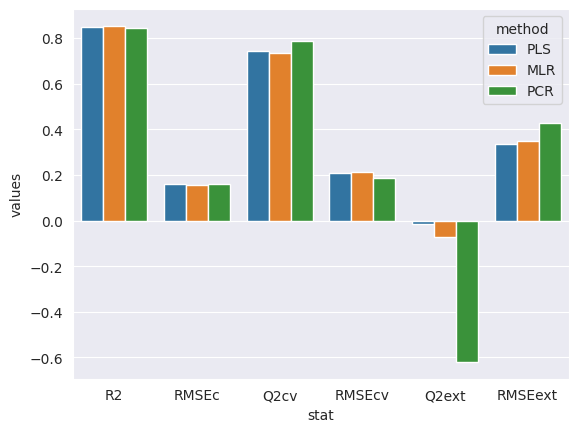

In [51]:
sns.barplot(
    stats, x='stat', y='values', hue='method'
)

Analiza wyników uzyskane dla tych samych danych metodami PLS, MLR i PCR daje następujące wyniki:
* $R^2$, $RMSE_c$ jest praktycznie takie samo dla wszystkich modeli, co oznacza, że tak samo dobrze sobie radzą z przewidywaniem wartości dla zbioru treningowego
* $Q^2_{cv}$ i $RMSE_{cv}$ wskazują, że model PCR jest najbardziej elastyczny
* $Q^2_{ext}$ i $RMSE_{ext}$ wskazują na to, że żaden model nie nadaje się do tworzenia tworzenia przewidywań. Wartości $Q^2_{ext} < 0$ oznaczają, że bardziej sprawdziłoby się używanie średniej niż modelu do tworzenia przewidywań. Różnica pomiedzy $R^2$ i $Q^2_{ext}$ $>0.3$ oznacza, że model nie jest zdolny do tworzenia przewidywań.

Propozycje potencjalnych rozwiązań:
* Stworzenie nowych modeli wykorzystując inne zmienne
* Stworzenie nowych modeli PCR na podstawie większej ilości zmiennych na wejściu do PCA